In [1]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from vit_pytorch.efficient import ViT as ViT_efficient
from vit_pytorch import ViT

from performer_pytorch import Performer
from models.linformer import Linformer
from models.nystromformer import Nystromformer
from transformers import LongformerModel, LongformerConfig
from models.longformer import ViT_for_longformer
from reformer_pytorch import Reformer
from models.reformer import ViT_for_reformer

from torch import Tensor
import time
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Subset

/Users/mikesong/miniconda3/envs/vit/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Plot validation accuracy

Text(0.5, 1.0, 'Caltech256 Validation Accuracy')

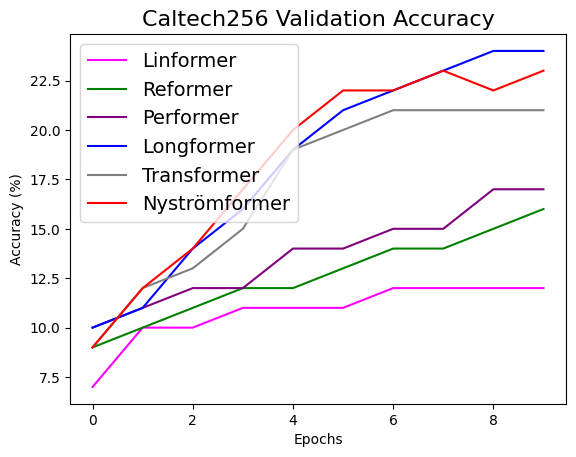

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
accuracies = {
    'Linformer' : [7, 10, 10, 11, 11, 11, 12, 12, 12, 12],
    'Reformer' : [9, 10, 11, 12, 12, 13, 14, 14, 15, 16],
    'Performer' : [10, 11, 12, 12, 14, 14, 15, 15, 17, 17],
    'Longformer' : [10, 11, 14, 16, 19, 21, 22, 23, 24, 24],
    'Transformer' : [9, 12, 13, 15, 19, 20, 21, 21, 21, 21],
    'Nyströmformer' : [9, 12, 14, 17, 20, 22, 22, 23, 22, 23]
}
pd.DataFrame(accuracies).plot(color=['magenta', 'green', 'purple', 'blue', 'grey', 'red'],
                              ylabel='Accuracy (%)', xlabel='Epochs')
plt.legend(fontsize = 14)
plt.title('Caltech256 Validation Accuracy', fontsize = 16)

# Load data Caltech101

In [3]:
num_classes = 101
image_size = 256
patch_size = 8
d_channel = 512

In [4]:
train_kwargs = {'batch_size': 32}
test_kwargs = {'batch_size': 256}

cuda_kwargs = {'num_workers': 6,
                'pin_memory': True,
                'shuffle': True}
train_kwargs.update(cuda_kwargs)
test_kwargs.update(cuda_kwargs)



normalize = transforms.Normalize(
    mean=(0.485,),
    std=(0.229,),
)
transform = transforms.Compose([
                        transforms.CenterCrop(256),
                        transforms.ToTensor(),
                        normalize,
                        ])

dataset1 = datasets.Caltech101('./data', download=True,
                    transform=transform)

# remove greyscale images, these indices are of RGB images
try:
    my_file = open("caltech101_rgb_indices.txt", "r")
    indices = my_file.read()
    indices = indices.split("\n")[:-1]
    indices = [int(x) for x in indices]
    my_file.close()
except:
    indices = []
    for i in range(len(dataset1)):
        if dataset1[i][0].shape[0] == 3: # is RGB image
            indices.append(i)
    with open("caltech101_rgb_indices.txt", 'w') as output:
        for row in indices:
            output.write(str(row) + '\n')

dataset1 = Subset(dataset1, indices)

dataset1, dataset2 = torch.utils.data.random_split(dataset1, 
            [int(len(dataset1)*0.8), len(dataset1)-int(len(dataset1)*0.8)],
            generator=torch.Generator().manual_seed(1))

Files already downloaded and verified


In [5]:
import matplotlib.pyplot as plt

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


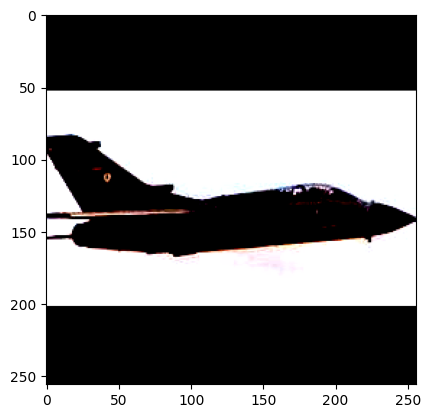

In [79]:
plt.imshow(dataset1[4][0].permute(1, 2, 0))
img = dataset1[4][0].reshape(1, 3, 256, 256)

In [139]:
from einops import rearrange, repeat
from einops.layers.torch import Rearrange
def compute_attention_for_Transformer(model, img):
    # image is a tensor of shape (1, 3, 256, 256)
    # get attention map for first transformer layer
    attention_list = []
    model.eval()
    with torch.no_grad():

        x = model.to_patch_embedding(img)
        b, n, _ = x.shape

        cls_tokens = repeat(model.cls_token, '1 1 d -> b 1 d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += model.pos_embedding[:, :(n + 1)]
        x = model.dropout(x)

        # before transformer

        # transformer
        for attn, ff in model.transformer.layers:
            # before attention
            x_original = x

            x = attn.norm(x)

            qkv = attn.to_qkv(x).chunk(3, dim = -1)
            q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = attn.heads), qkv)

            dots = torch.matmul(q, k.transpose(-1, -2)) * attn.scale

            attention = attn.attend(dots)
            attention = attn.dropout(attention)
            attention_list.append(attention)
            out = torch.matmul(attention, v)
            out = rearrange(out, 'b h n d -> b n (h d)')
            x = attn.to_out(out)

            # after attention
            # x = attn(x) + x
            x = x + x_original
            
            x = ff(x) + x

        x = model.transformer.norm(x)


        # x = model.transformer(x)

        # after transformer
        x = x.mean(dim = 1) if model.pool == 'mean' else x[:, 0]

        x = model.to_latent(x)
        x = model.mlp_head(x)

    return attention_list, x


from einops import rearrange, repeat
from einops.layers.torch import Rearrange
def compute_attention_for_Nyströmformer(model, img):
    # image is a tensor of shape (1, 3, 256, 256)
    # get attention map for first transformer layer
    attention_list = []
    model.eval()
    with torch.no_grad():

        x = model.to_patch_embedding(img)
        b, n, _ = x.shape

        cls_tokens = repeat(model.cls_token, '() n d -> b n d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += model.pos_embedding[:, :(n + 1)]

        # before transformer
        for attn, ff in model.transformer.layers:
            x_original = x
            x, attention = attn(x, mask = None, return_attn=True)
            attention_list.append(attention)
            x = x_original + x
            x = ff(x) + x


        # after transformer
        x = x.mean(dim = 1) if model.pool == 'mean' else x[:, 0]

        x = model.to_latent(x)
        x = model.mlp_head(x)

    return attention_list, x


from einops import rearrange, repeat
from einops.layers.torch import Rearrange
def compute_attention_for_Performer(model, img):
    # image is a tensor of shape (1, 3, 256, 256)
    # get attention map for first transformer layer
    attention_list = []
    model.eval()
    with torch.no_grad():

        x = model.to_patch_embedding(img)
        b, n, _ = x.shape

        cls_tokens = repeat(model.cls_token, '() n d -> b n d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += model.pos_embedding[:, :(n + 1)]
        
        # before transformer
        # x = model.transformer.net(x)
        for attn, ff in model.transformer.layers:
            x_original = x
            x, attention = attn(x, mask = None, return_attn=True)
            attention_list.append(attention)
            x = x_original + x
            x = ff(x) + x

        # after transformer
        x = x.mean(dim = 1) if model.pool == 'mean' else x[:, 0]

        x = model.to_latent(x)
        x = model.mlp_head(x)

    return attention_list, x
        

# transformer

In [156]:
model = ViT(
    dim = d_channel,
    mlp_dim = d_channel,
    image_size = image_size,
    patch_size = patch_size,
    num_classes = num_classes,
    depth = 8,
    heads = 1,
    dropout = 0.,
    emb_dropout = 0.
)
model_name = 'Transformer'
print(f"Total number of parameters in the model: {count_parameters(model)}")
model.load_state_dict(torch.load('./checkpts/Caltech101_heads_1/vit_transformer_patch_size_8/model.pt', map_location=torch.device('cpu')))

Total number of parameters in the model: 5949925


<All keys matched successfully>

tensor([5])


<Figure size 1200x900 with 0 Axes>

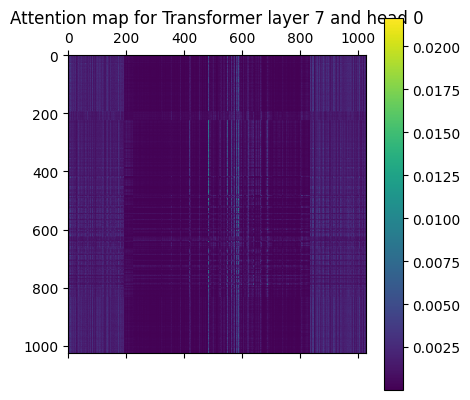

<Figure size 1200x900 with 0 Axes>

In [161]:
attention_list, x = compute_attention_for_Transformer(model, img)
layer = 7
head = 0
print(x.argmax(dim=1))
plt.matshow(attention_list[layer][0, head, :, :].reshape(1025, 1025).to('cpu').numpy())
plt.title(f'Attention map for {model_name} layer {layer} and head {head}')
plt.colorbar()
plt.figure(figsize=(12,9))

<Figure size 1200x900 with 0 Axes>

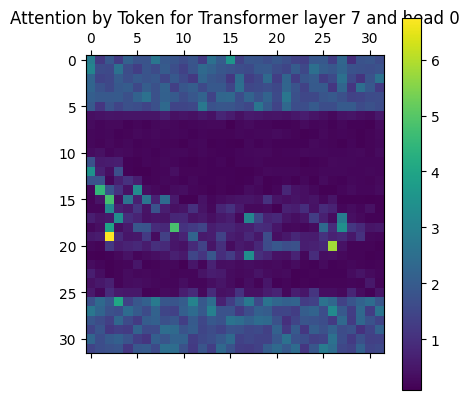

<Figure size 1200x900 with 0 Axes>

In [162]:
plt.matshow(attention_list[layer][0, head, 1:, 1:].reshape(1024, 1024).to('cpu').numpy().sum(axis=0).reshape(32, 32))
plt.title(f'Attention by Token for {model_name} layer {layer} and head {head}')
plt.colorbar()
plt.figure(figsize=(12,9))

# Performer

In [134]:
transformer = Performer(
    dim = d_channel,
    depth = 8,
    heads = 1,
    causal = False,
    dim_head = 64,
    ff_mult = 1,
    generalized_attention = True,
    kernel_fn = nn.ReLU(),
    nb_features = 64, # if nb_features is 0, then use None as projection_matrix in generalized kernel function \
                                    # which means using determinisitc feature projection \
                                    # you need to first cd to "~/anaconda3/envs/vit/lib/python3.8/site-packages/performer_pytorch" \
                                    # edit "performer_pytorch.py": add "if nb_full_blocks == 0: return None" after Line 143
    feature_redraw_interval = 0
)

model = ViT_efficient(
    dim = d_channel,
    image_size = image_size,
    patch_size = patch_size,
    num_classes = num_classes,
    transformer = transformer
)
model_name = 'Performer'
print(f"Total number of parameters in the model: {count_parameters(model)}")
model.load_state_dict(torch.load('./checkpts/Caltech101_heads_1/vit_performer_relu_patch_size_8_nb_features_64_feature_redraw_interval_1000/model.pt', map_location=torch.device('cpu')))

Total number of parameters in the model: 5951461


<All keys matched successfully>

# Nystromformer

In [163]:
from models.nystromformer import Nystromformer

transformer = Nystromformer(
        dim = d_channel,
        dim_head = 64,
        depth = 8,
        heads = 1,
        num_landmarks = 16,
        pinv_iterations = 6
        )

model = ViT_efficient(
    dim = d_channel,
    image_size = image_size,
    patch_size = patch_size,
    num_classes = num_classes,
    transformer = transformer
)
model_name = 'Nyströmformer'
print(f"Total number of parameters in the model: {count_parameters(model)}")
model.load_state_dict(torch.load('./checkpts/Caltech101_heads_1/vit_nystromformer_patch_size_8_num_landmarks_32_pinv_iterations_6/model.pt', map_location=torch.device('cpu')))

Total number of parameters in the model: 5950189


<All keys matched successfully>

tensor([5])


<Figure size 1200x900 with 0 Axes>

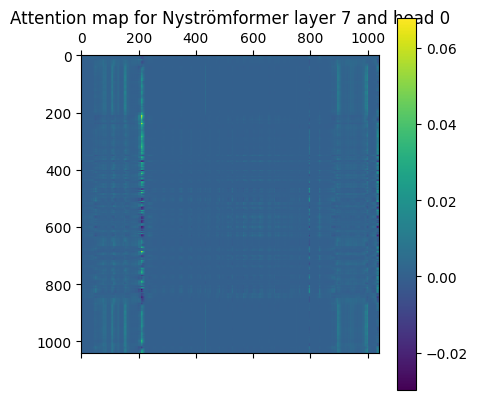

<Figure size 1200x900 with 0 Axes>

In [164]:
attention_list, x = compute_attention_for_Nyströmformer(model, img)
layer = 7
head = 0
print(x.argmax(dim=1))
attention = attention_list[layer][0, head, :, :].reshape(1040, 1040).to('cpu').numpy()
# attention -= attention.min()
plt.matshow(attention)
plt.title(f'Attention map for {model_name} layer {layer} and head {head}')
plt.colorbar()
plt.figure(figsize=(12,9))

<Figure size 1200x900 with 0 Axes>

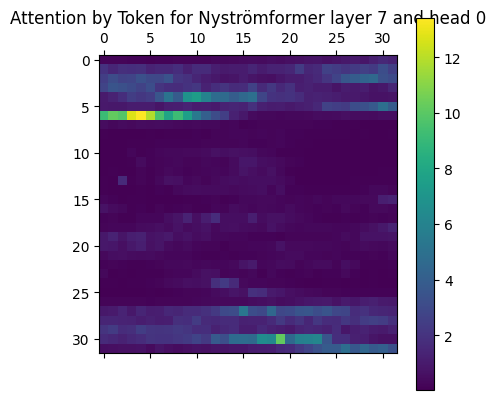

<Figure size 1200x900 with 0 Axes>

In [165]:
attention = attention_list[layer][0, head, 16:, 16:].reshape(1024, 1024).to('cpu').numpy()
# attention -= attention.min()
plt.matshow(attention.sum(axis=0).reshape(32, 32))
plt.title(f'Attention by Token for {model_name} layer {layer} and head {head}')
plt.colorbar()
plt.figure(figsize=(12,9))

# Linformer

In [130]:
from models.linformer import Linformer
transformer = Linformer(
    dim = d_channel,
    seq_len = int((image_size/patch_size)**2+1),
    depth = 8,
    heads = 8,
    k = 64,
    dim_head = 64,
    one_kv_head = True,
    share_kv = True
    )

model = ViT_efficient(
    dim = d_channel,
    image_size = image_size,
    patch_size = patch_size,
    num_classes = num_classes,
    transformer = transformer
)

model_name = 'Transformer'
print(f"Total number of parameters in the model: {count_parameters(model)}")
model.load_state_dict(torch.load('./checkpts/Caltech101/vit_linformer_patch_size_8_k_64_one_kv_head_True/model.pt', map_location=torch.device('cpu')))


Total number of parameters in the model: 14080997


<All keys matched successfully>

# Longformer

In [47]:
from transformers import LongformerModel, LongformerConfig
from models.longformer import ViT_for_longformer

In [53]:
config = LongformerConfig(
    attention_window=128,
    hidden_size=int(d_channel/2),
    num_attention_heads=8, 
    num_hidden_layers=8, 
    max_position_embeddings=4097,
    intermediate_size=d_channel
    )
transformer = LongformerModel(config)

model = ViT_for_longformer(
    dim = d_channel,
    image_size = image_size,
    patch_size = patch_size,
    num_classes = num_classes,
    transformer = transformer
)

print(f"Total number of parameters in the model: {count_parameters(model)}")
model

Total number of parameters in the model: 15403493


ViT_for_longformer(
  (to_patch_embedding): Sequential(
    (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=8, p2=8)
    (1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
    (2): Linear(in_features=192, out_features=512, bias=True)
    (3): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (transformer): LongformerModel(
    (embeddings): LongformerEmbeddings(
      (word_embeddings): Embedding(30522, 256, padding_idx=1)
      (token_type_embeddings): Embedding(2, 256)
      (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (position_embeddings): Embedding(4097, 256, padding_idx=1)
    )
    (encoder): LongformerEncoder(
      (layer): ModuleList(
        (0-7): 8 x LongformerLayer(
          (attention): LongformerAttention(
            (self): LongformerSelfAttention(
              (query): Linear(in_features=256, out_features=256, bias=True)
              (key): Linear(in_features=2

# Reformer

In [58]:
from models.reformer import ViT_for_reformer

transformer = Reformer(
    dim = d_channel,
    depth = 8,
    heads = 8,
    bucket_size = 32,
    n_hashes = 1,
    ff_mult = 1,
    reverse_thres = 4096,
    lsh_dropout = 0,
    causal = False
    )


model = ViT_for_reformer(
    dim = d_channel,
    image_size = image_size,
    patch_size = patch_size,
    num_classes = num_classes,
    transformer = transformer
)

print(f"Total number of parameters in the model: {count_parameters(model)}")
model

Total number of parameters in the model: 11191781


ViT_for_reformer(
  (to_patch_embedding): Sequential(
    (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=8, p2=8)
    (1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
    (2): Linear(in_features=192, out_features=512, bias=True)
    (3): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (transformer): Reformer(
    (layers): ReversibleSequence(
      (blocks): ModuleList(
        (0-7): 8 x ReversibleBlock(
          (f): Deterministic(
            (net): PreNorm(
              (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
              (fn): LSHSelfAttention(
                (toqk): Linear(in_features=512, out_features=512, bias=False)
                (tov): Linear(in_features=512, out_features=512, bias=False)
                (to_out): Linear(in_features=512, out_features=512, bias=True)
                (lsh_attn): LSHAttention(
                  (dropout): Dropout(p=0, inplace=False)
                  (dropout_for_hash): Dropout(p=0.0